In [1]:
import cv2,os
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from matplotlib import pyplot as plt

In [2]:
data_path='dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'with mask': 0, 'without mask': 1}
['with mask', 'without mask']
[0, 1]


In [3]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [4]:
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

new_target=np_utils.to_categorical(target)

np.save('data',data)
np.save('target',new_target)



In [5]:
data=np.load('data.npy')
target=np.load('target.npy')

#loading the save numpy arrays in the previous code

In [6]:
model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 200)       2000      
_________________________________________________________________
activation (Activation)      (None, 98, 98, 200)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 100)       180100    
_________________________________________________________________
activation_1 (Activation)    (None, 47, 47, 100)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 52900)             0

In [8]:
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [9]:
checkpoint = ModelCheckpoint('model.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=50,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.7267 - accuracy: 0.5364WARNING:tensorflow:From C:\Users\bothb\anaconda3\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model.model\assets
31/31 [==============================] - 44s 1s/step - loss: 0.7267 - accuracy: 0.5364 - val_loss: 0.6905 - val_accuracy: 0.5121
Epoch 2/50
31/31 [==============================] - 43s 1s/step - loss: 0.5765 - accuracy: 0.6848 - val_loss: 0.4731 - val_accuracy: 0.7903
Epoch 3/50
31/31 [==============================] - 43s 1s/step - loss: 0.3866 - accuracy: 0.8283 - val_loss

31/31 [==============================] - 41s 1s/step - loss: 0.0107 - accuracy: 0.9949 - val_loss: 0.2874 - val_accuracy: 0.9274
Epoch 48/50
31/31 [==============================] - 41s 1s/step - loss: 0.0084 - accuracy: 0.9980 - val_loss: 0.4458 - val_accuracy: 0.9395
Epoch 49/50
31/31 [==============================] - 41s 1s/step - loss: 0.0116 - accuracy: 0.9970 - val_loss: 0.2575 - val_accuracy: 0.9234
Epoch 50/50
31/31 [==============================] - 41s 1s/step - loss: 0.0057 - accuracy: 0.9970 - val_loss: 0.2473 - val_accuracy: 0.9355


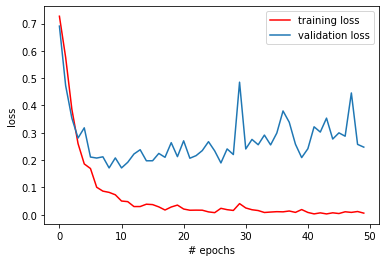

In [10]:


plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [11]:
score = model.evaluate(test_data,test_target, verbose=0)

print('Loss is {:.2f}'.format(score[0]) , 'Accuracy: {:.2f}'.format(score[1]) )
print('Accuracy: {:.2f}'.format((score[1]*100)) , '%')

Loss is 0.13 Accuracy: 0.96
Accuracy: 95.65 %


In [30]:
model = load_model('model.model')

face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

source=cv2.VideoCapture(0)

labels_dict={0:'MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [31]:
while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()